# Hagen-Poiseuille flow


## Description

Simulate transition from uniform plug inlet to fully developed parabolic profile in laminar pipe flow.

### Entrance length (99% developed)

L_e / D ≈ 0.06 × Re_D (theoretical approximation for Re < 2300)
### Recommended domain length
L ≥ 1.5–2.5 × L_e (ideally L/D ≈ 12–20)

### Typical test case (recommended starting point)

- Radius r = 0.5 → D = 1.0
- Re_D = 100 → L_e ≈ 6.0
- Tube length L = 15.0 (L/D = 15)
- Inlet: uniform plug velocity U_avg = U_inlet = 0.1 (along z)
- Developed centerline velocity U_max = 2 × U_avg = 0.2
- Fluid: ρ = 1.0, μ = (ρ U_avg D) / Re_D = 0.001
- Pressure gradient G = 8 μ U_avg / r² ≈ 0.0032 (for reference)

## Mesh recommendations

- Radial resolution: ≥ 10–12 points from center to wall
- Axial spacing: Δz ≈ 0.05–0.15
- cube_to_tube(r=0.5, refinements=2–3, height=L)
- Use cdist=1e-10 for merging

## Boundary conditions summary

- Walls: no-slip (u = 0 on side_boundary)
- Inlet: new vertex layers with fixed plug velocity U_z = U_avg
- Outlet: free outflow (remove exiting vertices, fixed P=0 or do-nothing)

## Validation targets

- Radial velocity profiles u_z(r) at z = 0, L_e/2, L_e, 1.5 L_e, 2 L_e
- Centerline velocity growth vs z
- Mass conservation (total ∑ m_v should stay nearly constant)


### Analytical equilibrium initial conditions and tests

Key assumptions (tunable via parameters):

- Tube/channel along z-axis (3D) or x-axis (2D planar).
- No-slip walls (velocity = 0 at boundary).
- 3D: axisymmetric Hagen-Poiseuille, radial coordinate r = sqrt(x² + y²), max centerline velocity U_max.
- 2D: parabolic u_x(y) between plates at y = y_lb and y = y_ub.
- Pressure stored as vector v.P (diagonal gradient potential, per your code).
- Velocity stored as v.u (vector).
- Use your dudt, dP, du operators (they already support dim=3 via e_star/v_star).

Summary of parameters, ICs and BCs:

In [1]:
# General imports
import numpy as np
from scipy.spatial import Delaunay  # if needed for mesh checks
import matplotlib.pyplot as plt

# Import parameters from _params.py
from src._params import r, D, L, Re_D, U_avg, U_max, rho, mu, L_e_approx, G, refinements, cdist, inlet_layer_thickness, outlet_buffer, add_inlet_every, CFL_target, print_params
print_params()

# Geometry
from src._geometry import cube_to_tube

# Import analytical solutions and IC/ test functions
from src._analytical_equil import (
    poiseuille_analytical_2d,
    poiseuille_analytical_3d,
    P_gradient_analytical,
    set_equilibrium_IC_2d,
    set_equilibrium_IC_3d,
    test_analytical_equilibrium_2d,
    test_analytical_equilibrium_3d
)

=== Hagen–Poiseuille Developing Flow Configuration ===
Radius r          = 0.5 m
Diameter D        = 1.0 m
Tube length L     = 15.0 m  (L/D = 15.0)
Re_D              = 100
Entrance length   ≈ 6.00 m  (L_e/D ≈ 6.0)
Inlet U_avg       = 0.1 m/s
Developed U_max   = 0.2 m/s
Density ρ         = 1.0 kg/m³
Viscosity μ       = 0.00100 Pa·s
Pressure gradient G = 0.00320 Pa/m


Usage notes:

- Call set_equilibrium_IC_2d(HC, ...) or _3d after mesh creation (cube_to_tube or your incomp_poiseuille_2d).
- Adjust G (pressure gradient) or U_max/R to match your physical scaling.
- Run the test_* functions immediately after setting ICs; dudt should be machine-zero for exact equilibrium (up to discretization error in du/dP).
- If v.P vector length needs explicit 3-component handling, extend dP/du calls accordingly (your dim=3 path already exists).

In [2]:
# Library specific imports
#from ddgclib.dynamic_integrators._integrators_dynamic import dudt

In [3]:
# compute duals (and Delaunay dual from a set of points)
from ddgclib.barycentric._duals import compute_vd#, triang_dual

# import
from ddgclib.barycentric._duals import dudt

## Case specific setup and imports

In [4]:
from src._plot_helpers import (
    extract_radial_profiles,
    plot_radial_profiles,
    plot_centerline_velocity
)

In [5]:
# Compute the initial duals
HC = cube_to_tube(r=r, refinements=1, height=L)

# Apply equilibrium initial conditions
set_equilibrium_IC_3d(
    HC,
    U_max=U_max,
    R=r,
    G=G          # pressure gradient magnitude (positive → flow in +z)
)

# Build dual mesh
compute_vd(HC, cdist=1e-8)

In [6]:
# Quick manual check of max |dudt|
dudt_norms = []
for v in HC.V:
    pass
    #dudt_val = dudt(v, dim=3, mu=mu)
    #dudt_norms.append(np.linalg.norm(dudt_val))

In [7]:
if 1:
    # Optional: Quick radial profile check at mid-tube
    z_mid = 0.0
    profile_z = []
    profile_uz = []

    for v in HC.V:
        if abs(v.x_a[2] - z_mid) < 0.05:  # thin slice at mid-tube
            r_local = np.linalg.norm(v.x_a[:2])
            uz_anal = poiseuille_analytical_3d(v.x_a, U_max=U_max, R=r)
            profile_z.append(r_local)
            profile_uz.append(v.u[2])

    print(f"\nMid-tube centerline u_z ≈ {max(profile_uz):.4f} m/s (expected {U_max:.4f})")


Mid-tube centerline u_z ≈ 0.2000 m/s (expected 0.2000)


Generating verification plots...


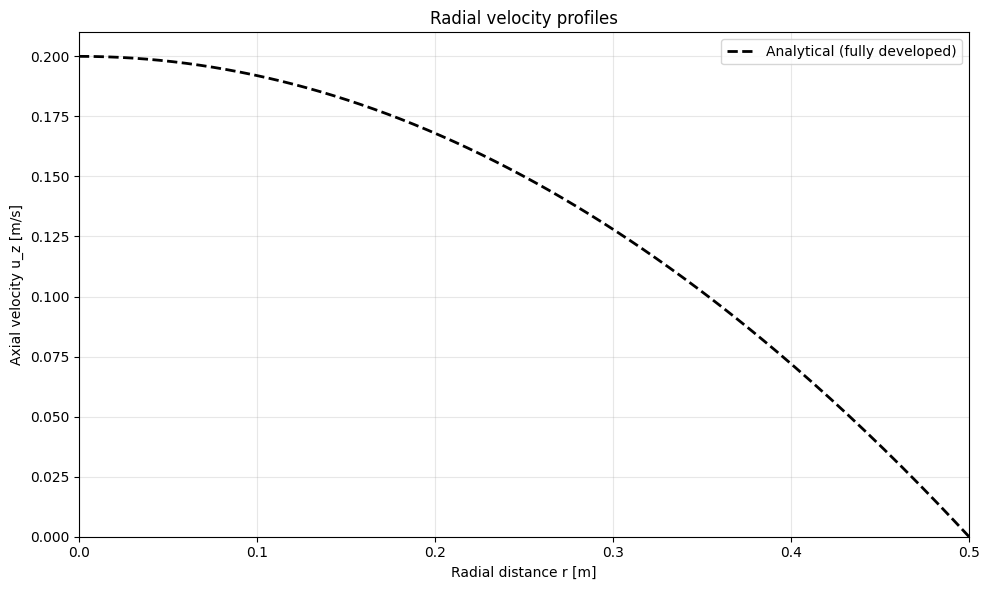

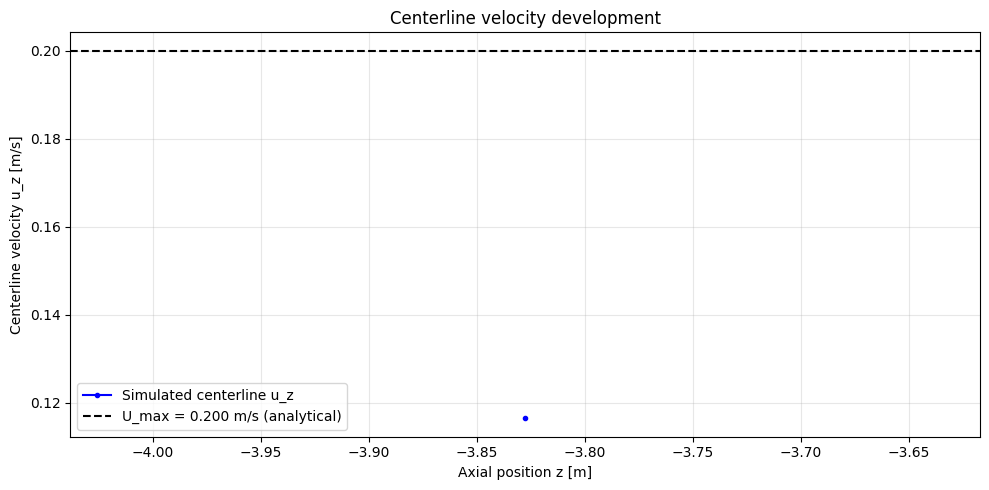

TypeError: Cannot cast array data from dtype('float128') to dtype('float64') according to the rule 'safe'

<Figure size 1000x800 with 2 Axes>

In [8]:

print("Generating verification plots...")
# Radial profiles at key locations
z_positions = [-L / 2 + 0.5, L / 4, L / 2, 3 * L / 4, L / 2 + 3]  # adjust as needed
profiles = extract_radial_profiles(HC, z_positions, dr_tol=0.08)
plot_radial_profiles(profiles, U_max=U_max, r_max=r)

# Centerline development
plot_centerline_velocity(HC, L, U_max=U_max)

# Optional simple 3D velocity magnitude visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
uz_vals = np.array([v.u[2] for v in HC.V])
scatter = ax.scatter([v.x_a[0] for v in HC.V],
                     [v.x_a[1] for v in HC.V],
                     [v.x_a[2] for v in HC.V],
                     c=uz_vals, cmap='viridis', s=15, alpha=0.8)
plt.colorbar(scatter, label='u_z [m/s]')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('Velocity magnitude distribution')
plt.show()>